# Manipulating audio annotations

This notebook demonstrates how to use the `annotations` module of OpenSoundscape to:

- load annotations from Raven files

- create a set of one-hot labels corresponding to fixed-length audio clips

- split a set of labeled audio files into clips and create labels dataframe for all clips

The audio recordings used in thise notebook were recorded by Andrew Spencer and are available under a Creative Commons License ([CC BY-NC-ND 2.5](https://creativecommons.org/licenses/by-nc-nd/2.5/)) from xeno-canto.org. Annotations were performed in Raven Pro software by our team.

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.annotations import BoxedAnnotations

import numpy as np
import pandas as pd
from glob import glob

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

### Download example files
Run the code below to download a set of example audio and raven annotations files for this tutorial. 

In [2]:
import subprocess
subprocess.run(['curl','https://pitt.box.com/shared/static/nzdzwwmyr3tkr6ig6sltw4b7jg3ptfe4.gz','-L', '-o','gwwa_audio_and_raven_annotations.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "gwwa_audio_and_raven_annotations.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "gwwa_audio_and_raven_annotations.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      4      0 --:--:--  0:00:01 --:--:--     7
100 5432k  100 5432k    0     0  2166k      0  0:00:02  0:00:02 --:--:-- 2166k


CompletedProcess(args=['rm', 'gwwa_audio_and_raven_annotations.tar.gz'], returncode=0)

## Load a single Raven annotation table from a txt file

We can use the BoxedAnnotation class's `from_raven_file` method to load a Raven .txt file into OpenSoundscape. This table contains the frequency and time limits of rectangular "boxes" representing each annotation that was created in Raven. 

Note that we need to specify the name of the column containing annotations, since it can be named anything in Raven. The column will be renamed to "annotation". 

This table looks a lot like what you would see in the Raven interface.

In [3]:
# specify an audio file and corresponding raven annotation file
audio_file = './gwwa_audio_and_raven_annotations/GWWA_XC/13738.wav'
annotation_file = './gwwa_audio_and_raven_annotations/GWWA_XC_AnnoTables/13738.Table.1.selections.txt'

Let's look at a spectrogram of the audio file to see what we're working with.

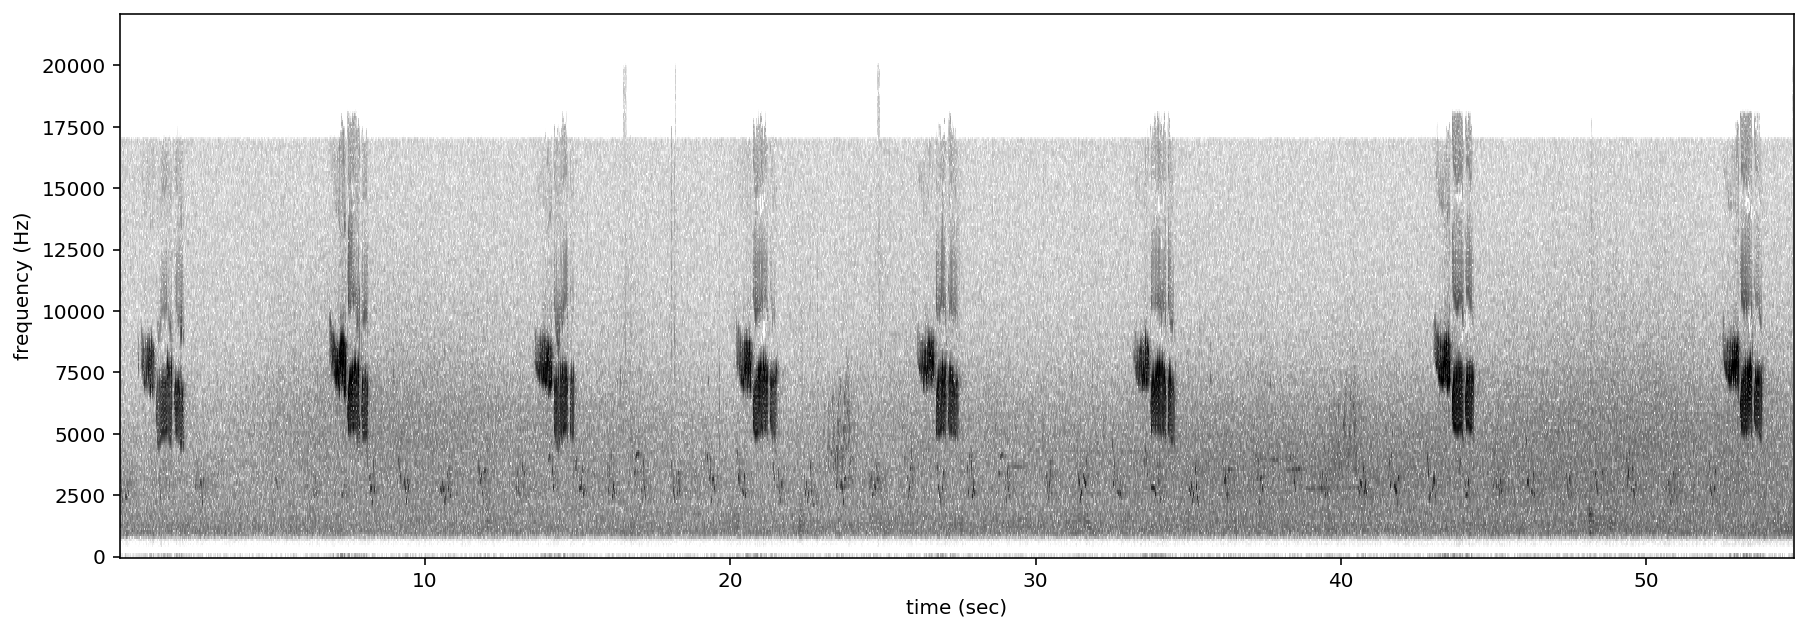

In [4]:
Spectrogram.from_audio(Audio.from_file(audio_file)).plot()

Now, let's load the annotations from the Raven annotation file.

In [5]:
#create an object from Raven file
annotations = BoxedAnnotations.from_raven_file(annotation_file,annotation_column='Species')

#inspect the object's .df attribute, which contains the table of annotations
annotations.df.head()

,Selection,View,Channel,start_time,end_time,low_f,high_f,annotation,Notes
0,1,Spectrogram 1,1,0.459636,2.298182,4029.8,17006.4,GWWA_song,NaN
1,2,Spectrogram 1,1,6.705283,8.246417,4156.6,17031.7,GWWA_song,NaN
2,3,Spectrogram 1,1,13.464641,15.005775,3903.1,17082.4,?,NaN
3,4,Spectrogram 1,1,20.128208,21.601748,4055.2,16930.3,GWWA_song,NaN
4,5,Spectrogram 1,1,26.047590,27.521131,4207.2,17057.1,GWWA_song,NaN


Note: if you **do not have an annotation column**, e.g.,  if you are annotating the sounds of a single species, the function above doesn't work in the current version of OpenSoundscape. A workaround is to use `annotation_column='Channel'`, in which case, the "annotation" of your file will be equal to the channel number. If your recordings are single-channel, then the "class" of every annotation will just be the number 1.

We could instead choose to only load the necessary columns (`start_time`, `end_time`, `low_f`, `high_f`, and `annotation`) using the `keep_extra_columns=None`. 

In this example, we use `keep_extra_columns=['Notes']` to keep only the Notes column.

In [6]:
annotations = BoxedAnnotations.from_raven_file(annotation_file,annotation_column='Species',keep_extra_columns=['Notes'])
annotations.df.head()

,start_time,end_time,low_f,high_f,annotation,Notes
0,0.459636,2.298182,4029.8,17006.4,GWWA_song,NaN
1,6.705283,8.246417,4156.6,17031.7,GWWA_song,NaN
2,13.464641,15.005775,3903.1,17082.4,?,NaN
3,20.128208,21.601748,4055.2,16930.3,GWWA_song,NaN
4,26.047590,27.521131,4207.2,17057.1,GWWA_song,NaN


## Convert or correct annotations
We can provide a DataFrame (e.g., from a .csv file) or a dictionary to convert original values to new values. 

Let's load up a little .csv file that specifies a set of conversions we'd like to make. The .csv file should have two columns, but it doesn't matter what they are called. If you create a table in Microsoft Excel, you can export it to a .csv file to use it as your conversion table. 

In [7]:
conversion_table = pd.read_csv('./gwwa_audio_and_raven_annotations/conversion_table.csv')
conversion_table

,original,new
0,gwwa_song,gwwa


Alternatively, we could simply write a Python dictionary for the conversion table. For instance:

In [8]:
conversion_table = {
    "GWWA_song":"GWWA",
    "?":np.nan
}

Now, we can apply the conversions in the table to our annotations.

This will create a new BoxedAnnotations object rather than modifying the original object (an "out of place operation").

In [9]:
annotations_corrected = annotations.convert_labels(conversion_table)
annotations_corrected.df

,start_time,end_time,low_f,high_f,annotation,Notes
0,0.459636,2.298182,4029.8,17006.4,GWWA,NaN
1,6.705283,8.246417,4156.6,17031.7,GWWA,NaN
2,13.464641,15.005775,3903.1,17082.4,NaN,NaN
3,20.128208,21.601748,4055.2,16930.3,GWWA,NaN
4,26.047590,27.521131,4207.2,17057.1,GWWA,NaN
5,33.121946,34.663079,4207.2,17082.4,GWWA,NaN
6,42.967925,44.427946,4181.9,17057.1,GWWA,NaN
7,52.417508,53.891048,4232.6,16930.3,GWWA,NaN


### View a subset of annotations
We can specify a list of classes to view annotations of.

For example, we can subset to only annotations marked as "?" - perhaps we're interested in looking at these annotations in Raven again to determine what class they really were.

In [10]:
classes_to_keep = ['?']
annotations_only_unsure = annotations.subset(classes_to_keep)
annotations_only_unsure.df

,start_time,end_time,low_f,high_f,annotation,Notes
2,13.464641,15.005775,3903.1,17082.4,?,NaN


### Saving annotations to Raven-compatible file
We can always save our BoxedAnnotations object to a Raven-compatible .txt file, which can be opened in Raven along with an audio file just like the .txt files Raven creates itself. You must specify a path for the save file that ends with `.txt`. 

In [11]:
annotations_only_unsure.to_raven_file('./gwwa_audio_and_raven_annotations/13738_unsure.txt')

## Split an audio clip and its annotations
Often, we want to train or validate models on short audio segments (e.g., 5 seconds) rather than on long files (e.g., 2 hours). 

To do this, we need two things:

* A saved set of short audio clips

* A table that associates each split audio clip with the annotations in the clip (e.g., which species, if any, are present in each clip). Usually these are in "one-hot encoding" form (see explanation below).

We can use OpenSoundscape to split annotations, and optionally, the audio clips associated with the annotations, in three ways: 

**Splitting both Audio and annotations:**

1. Split the audio first using `Audio.split()`, then use the DataFrame of clip start/end times returned by this function to split the annotations using `BoxedAnnotations.one_hot_labels_like()`

**Splitting annotations only:**

2. Use `BoxedAnnotations.one_hot_clip_labels()` to split the annotations in one step

3. Create a DataFrame of clip start/end times similar to the one generated by `Audio.split()`, then use it to split the annotations using `BoxedAnnotations.one_hot_labels_like()`

All three methods are demonstrated below.

***What is one-hot encoding?***

The functions below demonstrate the creation of one-hot encoded labels. 

This machine learning term, "one-hot encoding," refers to a way to format a table of labels in which:
* Each row represents a single sample, like a single 5-second long clip
* Each column represents a single possible class (e.g. one of multiple species)
* A "0" in a row and column means that in that sample, the class is not present
* A "1" is "hot," meaning that in that sample, the class *IS* present.

For example, let's say we had a 15-second audio clip that we were splitting into three 5s clips. Let's say we are training a classifier to identify coyotes and dogs, and we labeled the clip and found:
* a coyote howled from 2.5 to 4 seconds into the clip (so, only the first clip contains it)
* a dog barked from 4 seconds to 10 seconds into the clip (so, both the first and second clips contain it)
* and there was silence for the last 5 seconds of the clip (so, the third clip has neither coyotes nor dogs in it).

The one-hot encoded labels file for this example would look like:

In [12]:
pd.DataFrame({
    "start_time":[0, 5, 10],
    "end_time":[5, 10, 15],
    "COYOTE":[1, 0, 0],
    "DOG":[1, 1, 0]
})

,start_time,end_time,COYOTE,DOG
0,0,5,1,1
1,5,10,0,1
2,10,15,0,0


### 1. Split Audio object, then split annotations to match

First, split an Audio object with `Audio.split()`, which returns two things:

1. A list of audio clip objects

2. A dataframe of start/end times

In [13]:
# Load the Audio and Annotations
audio = Audio.from_file(audio_file)
annotations = BoxedAnnotations.from_raven_file(annotation_file, annotation_column='Species')

# Split the audio into 5 second clips with no overlap (we use _ because we don't really need to save the audio clip objects for this demo)
_, clip_df = audio.split(
    clip_duration=5.0, # How long each clip should be
    clip_overlap=0.0 # By how many seconds each subsequent clip should overlap
)
clip_df.head()

,start_time,end_time
0,0.0,5.0
1,5.0,10.0
2,10.0,15.0
3,15.0,20.0
4,20.0,25.0


Different overlap and duration settings produce different results:

In [14]:
# Split the audio into 5 second clips with no overlap (we use _ because we don't really need to save the audio clip objects for this demo)
_, clip_df_short_with_overlaps = audio.split(
    clip_duration=3.0, # How long each clip should be
    clip_overlap=1.0 # By how many seconds each subsequent clip should overlap
)
clip_df_short_with_overlaps.head()

,start_time,end_time
0,0.0,3.0
1,2.0,5.0
2,4.0,7.0
3,6.0,9.0
4,8.0,11.0


Next, extract annotations for each clip using `BoxedAnnotations.one_hot_labels_like()`. 

This function requires that we specify the minimum overlap of the label (in seconds) with the clip for the clip to be labeled positive. It also requires that we either (1) specify the list of classes for one-hot labels or (2) specify `classes=None`, which will make a column for every unique label in the annotations. In this example, that would include a "?" class.

In [15]:
# Split the annotations using the returned clip_df
labels_df = annotations.one_hot_labels_like(
    clip_df,
    min_label_overlap=0.25, # Minimum label overlap
    classes=['GWWA_song']
)

#the returned dataframe of one-hot labels (0/1 for each class and each clip) has rows corresponding to each audio clip
labels_df.head()

,,GWWA_song
start_time,end_time,
0.0,5.0,1.0
5.0,10.0,1.0
10.0,15.0,0.0
15.0,20.0,0.0
20.0,25.0,1.0


### 2. Split annotations directly using splitting parameters

If you prefer to split only annotations, you can do this using `one_hot_clip_labels()`. 

This method combines the two steps in the example above (creating a clip dataframe and splitting the annotations), and requires that you specify the parameters for both of those steps. 

Notice that we can't tell what the length of the entire audio file is from the annotation file alone, so we need to specify one additional parameter: the entire duration of the audio file to be split (`full_duration`).

Here's an example that produces equivalent results to the other examples:

In [16]:
labels_df = annotations.one_hot_clip_labels(
    full_duration=60, # The duration of the entire audio file
    clip_duration=5, 
    clip_overlap=0,
    classes=['GWWA_song'],
    min_label_overlap=0.25,
)
labels_df.head()

,,GWWA_song
start_time,end_time,
0,5,1.0
5,10,1.0
10,15,0.0
15,20,0.0
20,25,1.0


### 3. Split annotations using your own clip DF

A more verbose option than #2: we can split annotations using a separately created DataFrame of start and end times.

This method could be useful if you wished to hand-create the DataFrame of clip start and end times to have more control over the start and end times you were interested in.

In this example, we will use a helper function to create the DataFrame, `generate_clip_times_df()`, which takes the same splitting parameters as `Audio.split()`. 



In [17]:
# Generate clip start/end time DataFrame
from opensoundscape.helpers import generate_clip_times_df
clip_df = generate_clip_times_df(full_duration=60, clip_duration=5.0, clip_overlap=0.0)
clip_df.head()

,start_time,end_time
0,0.0,5.0
1,5.0,10.0
2,10.0,15.0
3,15.0,20.0
4,20.0,25.0


In [18]:
# We can use the clip_df to split the Annotations in the same way as before
labels_df = annotations.one_hot_labels_like(clip_df, min_label_overlap=0.25, classes=['GWWA_song'])

# The returned dataframe of one-hot labels (0/1 for each class and each clip) has rows corresponding to each audio clip
labels_df.head()

,,GWWA_song
start_time,end_time,
0.0,5.0,1.0
5.0,10.0,1.0
10.0,15.0,0.0
15.0,20.0,0.0
20.0,25.0,1.0


## Split many audio clips and their annotations

The steps above described how to split a single audio clip and its annotations.

In practice, we have tons of audio files with their corresponding Raven files. We need to:

* Pair up all the audio files with their Raven annotation files

* Split and save short audio clips

* Split and save the annotations corresponding to the audio clips

Let's walk through the steps required to do this. But be warned, pairing Raven files and audio files might require more finagling than shown here.

### Match up audio files and Raven annotations

The first step in the process is associating audio files with their corresponding Raven files. Perhaps not every audio file is annotated, and perhaps some audio files have been annotated multiple times. This code walks through some steps of sorting through these data to pair files.

**Caveat: you'll need to be careful** using the code below, depending on how your audio and Raven files are named and organized.

In this example, we'll assume that each audio file has the same name as its Raven annotation file (ignoring the extensions like ".Table.1.selections.txt"), which is the default naming convention when using Raven. We'll also start by assuming that the audio filenames *are unique (!)* - that is, no two audio files have the same name. 

First, find all the Raven files and all the audio files.

In [19]:
# Specify folder containing Raven annotations
raven_files_dir = "./gwwa_audio_and_raven_annotations/GWWA_XC_AnnoTables/"

# Find all .txt files
# We'll naively assume all files with the suffix ".txt" are Raven files! 
# A better assumption could be to search for files with the suffix ".selections.txt"
raven_files = glob(f"{raven_files_dir}/*.txt")
print(f"found {len(raven_files)} annotation files")

# Specify folder containing audio files
audio_files_dir = "./gwwa_audio_and_raven_annotations/GWWA_XC/"

# Find all audio files (we'll assume they are .wav, .WAV, or .mp3)
audio_files = glob(f"{audio_files_dir}/*.wav")+glob(f"{audio_files_dir}/*.WAV")+glob(f"{audio_files_dir}/*.mp3")
print(f"found {len(audio_files)} audio files")

found 3 annotation files
found 3 audio files


Next, starting by assuming that audio files have unique names, use the audio filenames to pair up the annotation files. Then, double-check that our assumption is correct.

In [20]:
# Pair up the Raven and audio files based on the audio file name
from pathlib import Path
audio_df = pd.DataFrame({'audio_file':audio_files})
audio_df.index = [Path(f).stem for f in audio_files]

# Check that there aren't duplicate audio file names
print('\n audio files with duplicate names:')
audio_df[audio_df.index.duplicated(keep=False)]


 audio files with duplicate names:


,audio_file


Seeing that no audio files have duplicate names, check to make sure the same is true for Raven files.

In [21]:
raven_df = pd.DataFrame({'raven_file':raven_files})
raven_df.index = [Path(f).stem.split('.Table')[0] for f in raven_files]

#check that there aren't duplicate audio file names
print('\n raven files with duplicate names:')
raven_df[raven_df.index.duplicated(keep=False)]


 raven files with duplicate names:


,raven_file
13738,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...
13738,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


Since we found some duplicate Raven files, resolve this issue by deleting the extra Raven file, which in this case was named "selections2".

In [22]:
#remove the second selection table for file 13738.wav
raven_df=raven_df[raven_df.raven_file.apply(lambda x: "selections2" not in x)]

Once we've resolved any issues with duplicate names, we can match up Raven and audio files.

In [23]:
paired_df = audio_df.join(raven_df,how='outer')

Check if any audio files don't have Raven annotation files:

In [24]:
print(f"audio files without raven file: {len(paired_df[paired_df.raven_file.apply(lambda x:x!=x)])}")
paired_df[paired_df.raven_file.apply(lambda x:x!=x)]

audio files without raven file: 2


,audio_file,raven_file
135601,./gwwa_audio_and_raven_annotations/GWWA_XC/135...,NaN
13742,./gwwa_audio_and_raven_annotations/GWWA_XC/137...,NaN


Check if any Raven files don't have audio files:

In [25]:
#look at unmatched raven files
print(f"raven files without audio file: {len(paired_df[paired_df.audio_file.apply(lambda x:x!=x)])}")

paired_df[paired_df.audio_file.apply(lambda x:x!=x)]

raven files without audio file: 1


,audio_file,raven_file
16989,NaN,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


In this example, let's discard any unpaired Raven or audio files.

In [26]:
paired_df = paired_df.dropna()

In [27]:
paired_df

,audio_file,raven_file
13738,./gwwa_audio_and_raven_annotations/GWWA_XC/137...,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


### Split and save the audio and annotations
Now we have a set of paired up Raven and audio files. 

Let's split each of the audio files and create the corresponding labels.

Note: this step will be confusing and annoying if your Raven files use different names for the annotation column. Ideally, all of your Raven files should have the same column name for the annotations. 

First, make a directory to put the split audio files in.

In [28]:
clip_dir = './temp_clips'
Path(clip_dir).mkdir(exist_ok=True)

Next, set up the settings for audio splitting:
* The duration of the clips

* Whether subsequent clips should overlap each other (e.g., `clip_overlap=1` would mean that the second clip started 1s before the first clip ended)

* What to do with the final clip if it would be less than `clip_duration` size (see API documentation for full information about the options for this)

* And the directory in which to save audio files.

In [29]:
# Choose settings for audio splitting
clip_duration = 3
clip_overlap = 0
final_clip = None
clip_dir = './temp_clips'

Next, set up the settings for annotation splitting:

* Whether to use a subset of classes

* How many seconds a label should overlap a clip, at minimum, in order for that clip to be labeled

In [30]:
# Choose settings for annotation splitting
classes = None #Equivalent to a list of all classes: ['GWWA_song', '?']
min_label_overlap = 0.1

We'll want to keep the names of the audio clips that we create using `Audio.split_and_save()` so that we can correspond them with one-hot clip labels.

In [31]:
# Store the label dataframes from each audio file so that we can aggregate them later
# Note: if you have a huge number (millions) of annotations, this might get very large. 
# An alternative would be to save the individual dataframes to files, then concatenate them later. 
all_labels = []

cnt = 0

for i, row in paired_df.iterrows():
    # Load the audio into an Audio object
    audio = Audio.from_file(row['audio_file'])
    
    # In this example, only the first 60 seconds of audio is annotated
    # So trim the audio to 60 seconds max
    audio = audio.trim(0,60)
    
    # Split the audio and save the clips
    clip_df = audio.split_and_save(
        clip_dir,
        prefix=row.name,
        clip_duration=clip_duration,
        clip_overlap=clip_overlap,
        final_clip=final_clip,
        dry_run=False
    )
    
    # Load the annotation file into a BoxedAnnotation object
    annotations = BoxedAnnotations.from_raven_file(row['raven_file'],annotation_column='Species')
    
    # Since we trimmed the audio, we'll also trim the annotations for consistency
    annotations = annotations.trim(0,60)
    
    # Split the annotations to match the audio
    # We choose to keep_index=True so that we retain the audio clip's path in the final label dataframe
    labels_df = annotations.one_hot_labels_like(clip_df,classes=classes,min_label_overlap=min_label_overlap,keep_index=True)
    
    # Since we have saved short audio clips, we can discard the start_time and end_time indices
    labels_df = labels_df.reset_index(level=[1,2],drop=True)
    all_labels.append(labels_df)
    
    cnt+=1
    if cnt>2:
        break

#make one big dataframe with all of the labels. We could use this for training, for instance. 
all_labels = pd.concat(all_labels)
all_labels.to_csv("temp_clips/clip_annotations.csv")
all_labels

,?,GWWA_song
file,,
./temp_clips/13738_0.0s_3.0s.wav,0.0,1.0
./temp_clips/13738_3.0s_6.0s.wav,0.0,0.0
./temp_clips/13738_6.0s_9.0s.wav,0.0,1.0
./temp_clips/13738_9.0s_12.0s.wav,0.0,0.0
./temp_clips/13738_12.0s_15.0s.wav,1.0,0.0
./temp_clips/13738_15.0s_18.0s.wav,0.0,0.0
./temp_clips/13738_18.0s_21.0s.wav,0.0,1.0
./temp_clips/13738_21.0s_24.0s.wav,0.0,1.0
./temp_clips/13738_24.0s_27.0s.wav,0.0,1.0


### Sanity check: look at spectrograms of clips labeled 0 and 1

In [32]:
# ignore the "?" annotations for this visualization
all_labels = all_labels[all_labels["?"]==0]

Note: replace the "GWWA_song" here with a class name from your own dataset.

spectrograms of 3 random positive clips (label=1)


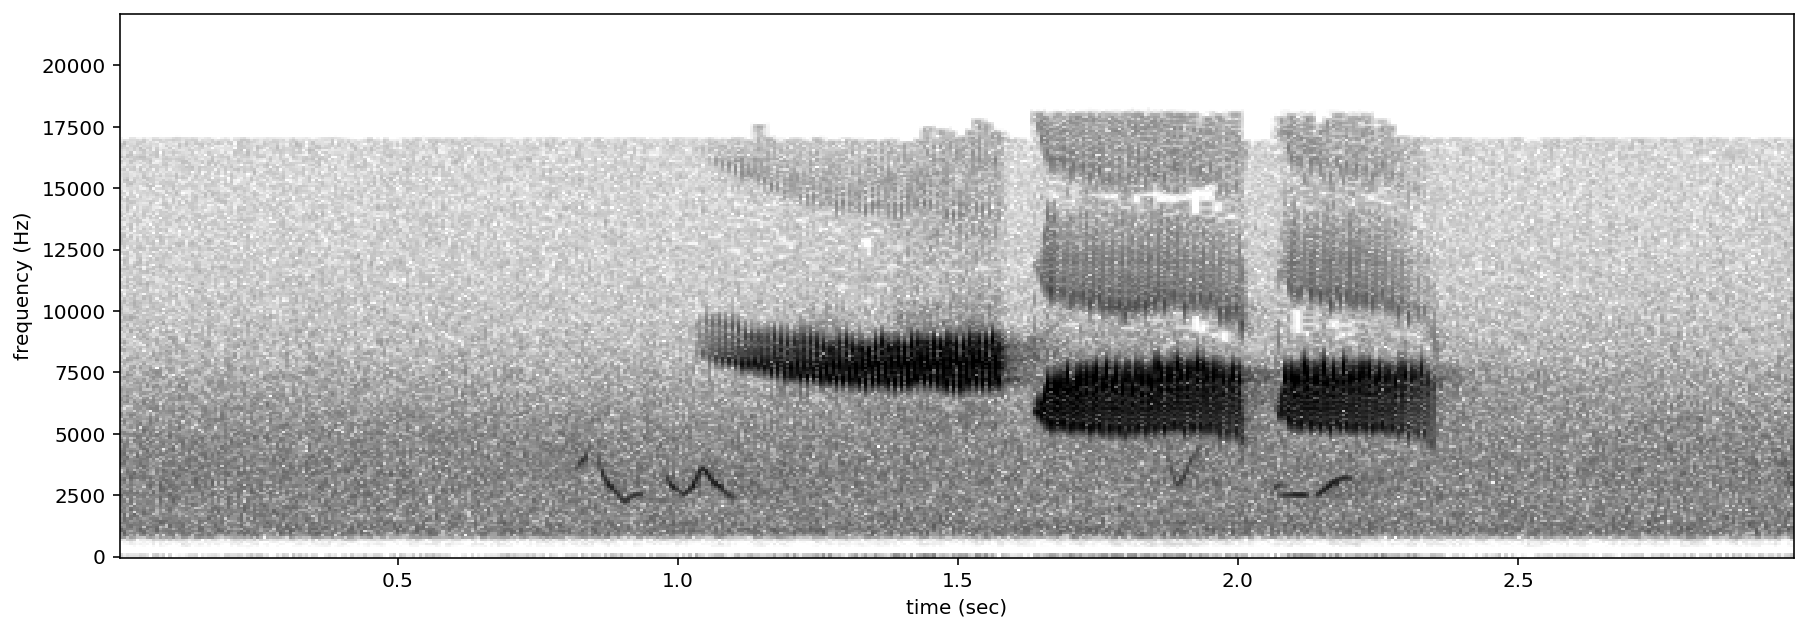

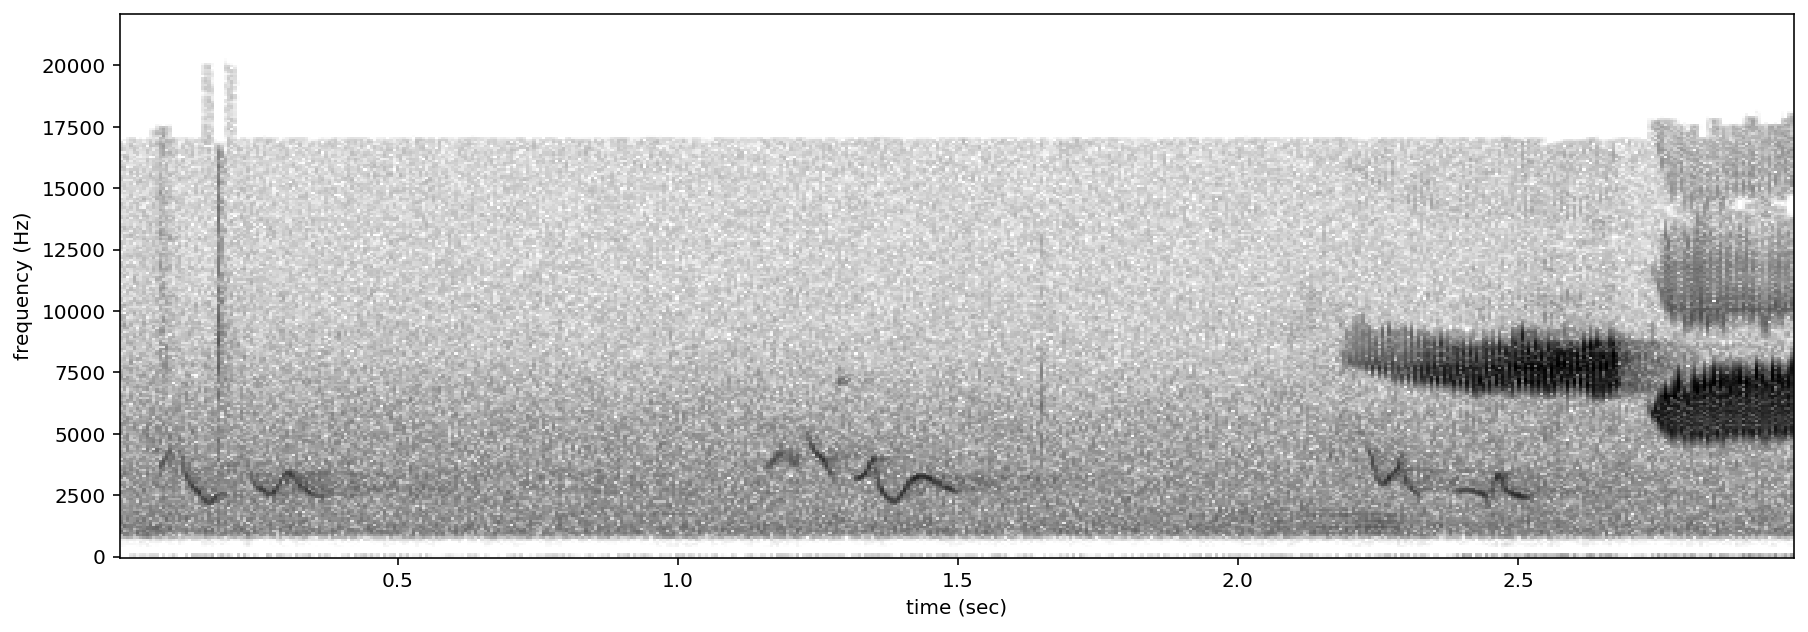

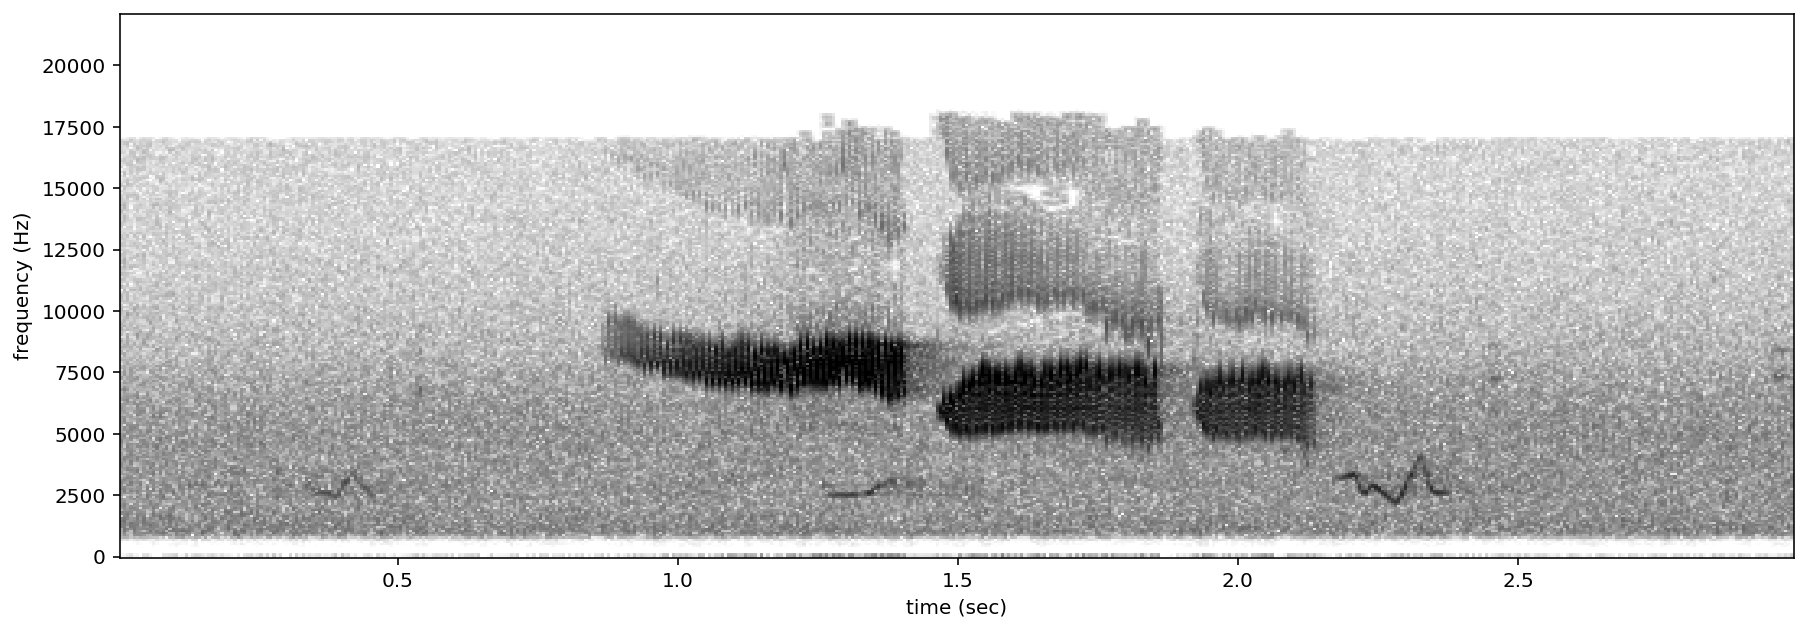

spectrogram of 3 random negative clips (label=0)


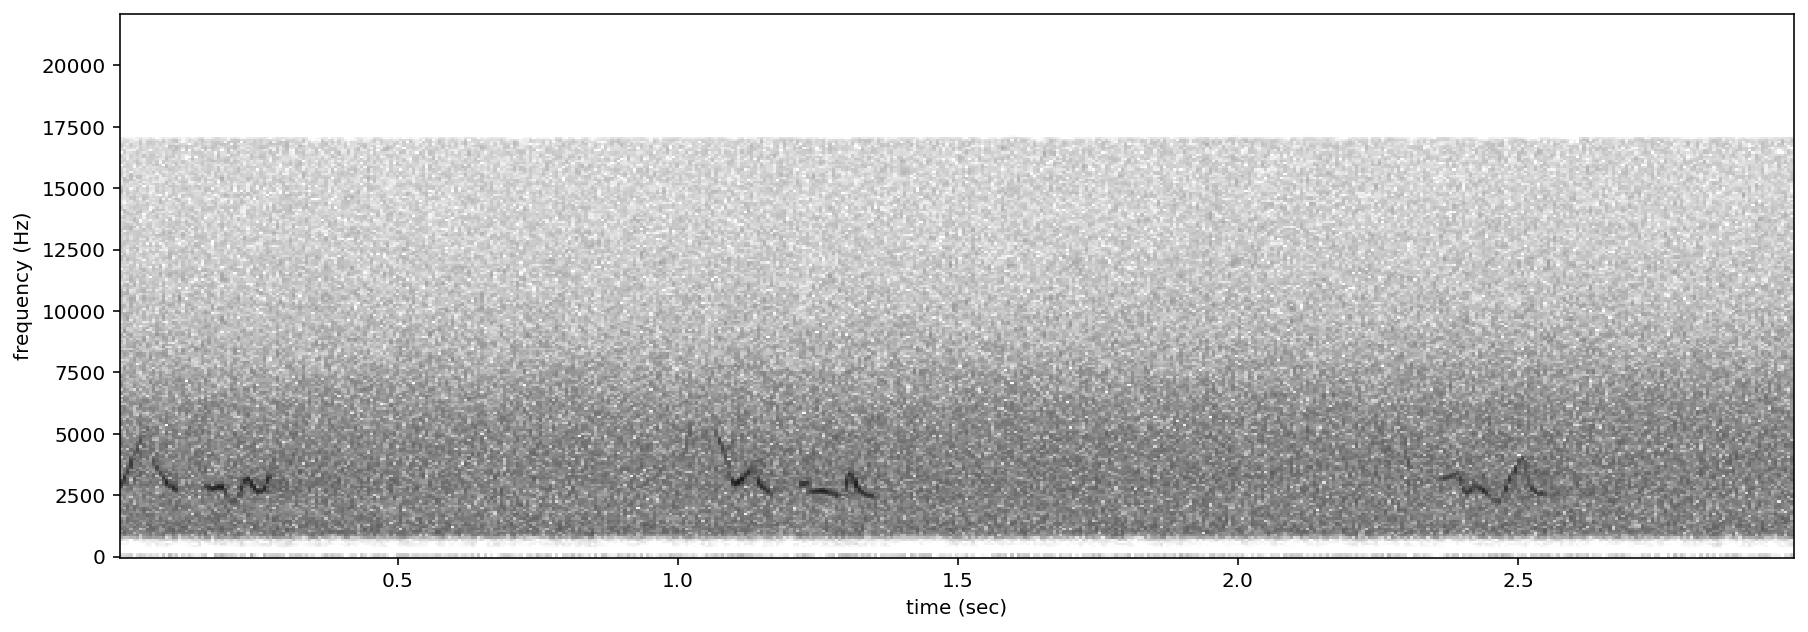

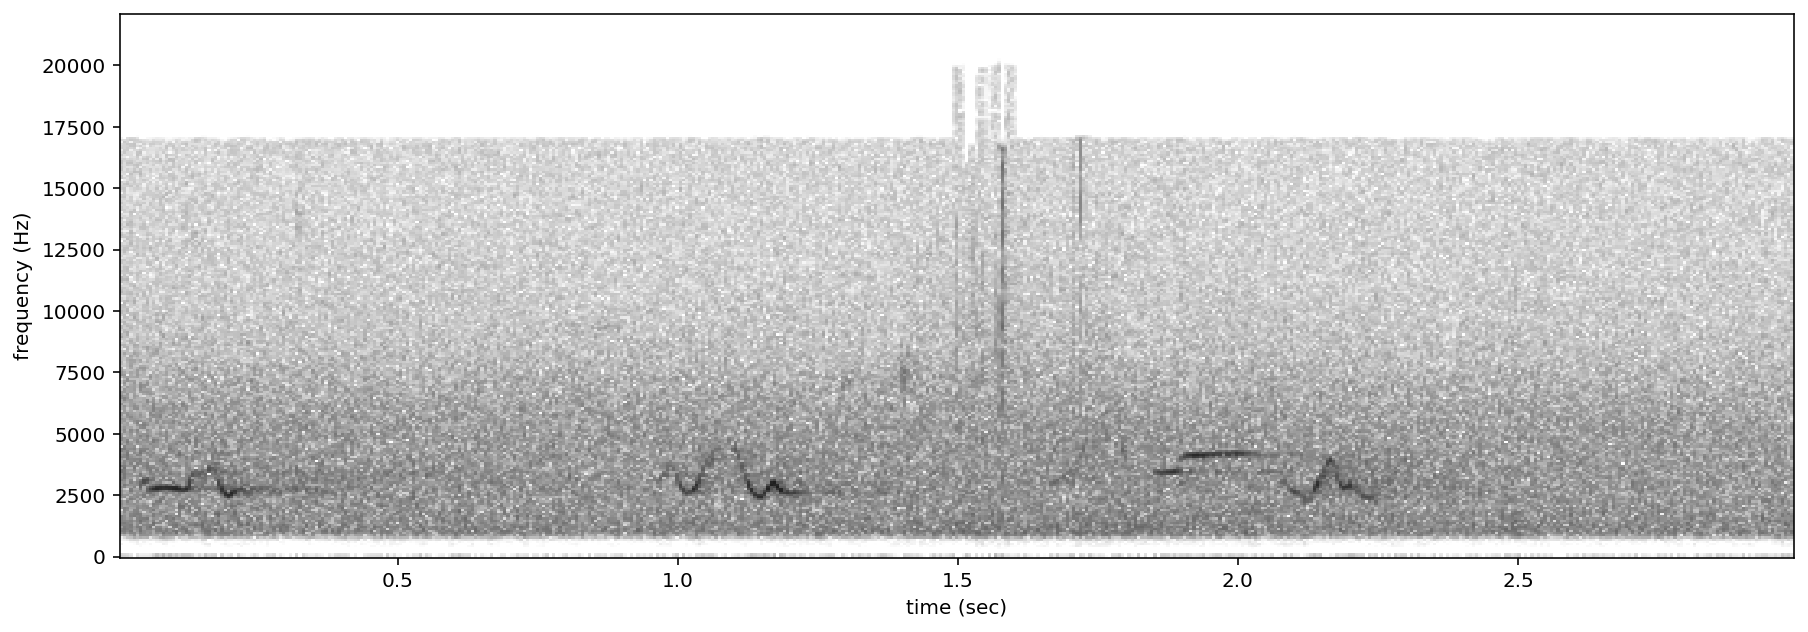

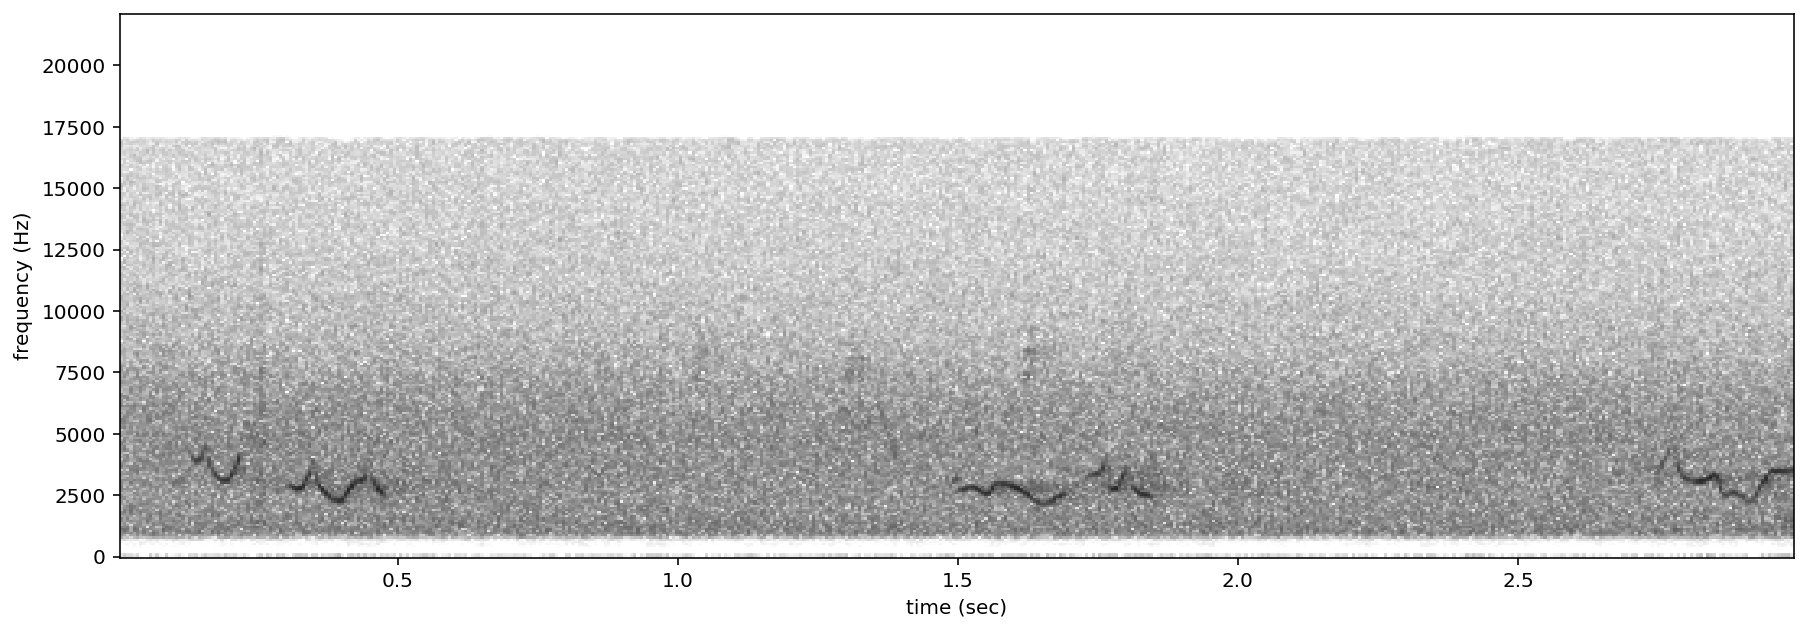

In [33]:
# plot spectrograms for 3 random positive clips
positives = all_labels[all_labels['GWWA_song']==1].sample(3,random_state=0)
print("spectrograms of 3 random positive clips (label=1)")
for positive_clip in positives.index.values:
    Spectrogram.from_audio(Audio.from_file(positive_clip)).plot()

# plot spectrograms for 5 random negative clips
negatives = all_labels[all_labels['GWWA_song']==0].sample(3,random_state=0)
print("spectrogram of 3 random negative clips (label=0)")
for negative_clip in negatives.index.values:
    Spectrogram.from_audio(Audio.from_file(negative_clip)).plot()


Clean up: remove the sounds that we downloaded for this tutorial as well as the `temp_clips` directory containing the split, saved clips.

In [34]:
import shutil
shutil.rmtree('./gwwa_audio_and_raven_annotations')
shutil.rmtree('./temp_clips')